In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os

In [2]:
# if using google colab, upload the zip file and then run this cell to unzip the file.
!unzip PianoFingeringDataset_v1.2.zip

Archive:  PianoFingeringDataset_v1.2.zip
   creating: PianoFingeringDataset_v1.2/
  inflating: __MACOSX/._PianoFingeringDataset_v1.2  
  inflating: PianoFingeringDataset_v1.2/.DS_Store  
  inflating: __MACOSX/PianoFingeringDataset_v1.2/._.DS_Store  
   creating: PianoFingeringDataset_v1.2/FingeringFiles/
  inflating: __MACOSX/PianoFingeringDataset_v1.2/._FingeringFiles  
  inflating: PianoFingeringDataset_v1.2/List.pdf  
  inflating: __MACOSX/PianoFingeringDataset_v1.2/._List.pdf  
  inflating: PianoFingeringDataset_v1.2/List.csv  
  inflating: __MACOSX/PianoFingeringDataset_v1.2/._List.csv  
  inflating: PianoFingeringDataset_v1.2/README-ja.pdf  
  inflating: __MACOSX/PianoFingeringDataset_v1.2/._README-ja.pdf  
  inflating: PianoFingeringDataset_v1.2/README.pdf  
  inflating: __MACOSX/PianoFingeringDataset_v1.2/._README.pdf  
   creating: PianoFingeringDataset_v1.2/ScorePDF/
  inflating: __MACOSX/PianoFingeringDataset_v1.2/._ScorePDF  
  inflating: PianoFingeringDataset_v1.2/Fingerin

# Data Preparation and Setup

We have metadata about the pieces as well as the actual fingering data itself. This is how you load it in and make necessary modifications.

In [2]:
# This cell loads in 'lists.csv', which is a simple CSV file that links IDs to actual pieces, with some extra metadata about the pieces themselves
song_metadata_dir_path = 'PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/'
metadata_csv_file_name = 'List.csv'
file_path = os.path.join(song_metadata_dir_path, metadata_csv_file_name)

if os.path.isfile(file_path):
    song_metadata_df = pd.read_csv(file_path, skiprows=1, names=["id", "composer", "piece", "num_bars", "num_notes", "num_types_of_fingerings_provided", "fingering_1", "fingering_2", "fingering_3", "fingering_4", "fingering_5", "fingering_6", "fingering_7", "fingering_8"])
else:
    print("invalid filepath!")    


song_metadata_df.head(5)

,id,composer,piece,num_bars,num_notes,num_types_of_fingerings_provided,fingering_1,fingering_2,fingering_3,fingering_4,fingering_5,fingering_6,fingering_7,fingering_8
0,1,Bach,Two-part invention in C major,22,469,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
1,2,Bach,Two-part invention in F major,34,596,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
2,3,Bach,"Well-Tempered Clavier, Book I, Prelude No. 23 ...",19,417,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
3,4,Bach,"Well-Tempered Clavier, Book II, Fugue No. 2 in...",14,282,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH
4,5,Bach,"Well-Tempered Clavier, Book II, Fugue No. 19 i...",14,313,4,YI,ES,NaN,NaN,HI,NaN,NaN,NH


In [3]:
# This cell shows how to load in a specific fingering file and also the relevant data
directory_path = 'PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/FingeringFiles/'    # modify this directory path as needed


# Sample code for loading in a the fingering dataset
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    
    fingering_label, _ = filename.split('_')     # 001-01
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)
    
    if os.path.isfile(file_path):
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
    else:
        print("some error in filepath name!")
        break
        
    print(f"Data for {song_metadata_df.iloc[piece_id]["piece"]}")
    print(df.head(5))
    print(df.dtypes)




Data for Piano Sonata K 331 in A major, 3rd mov.
   noteID  onset_time  offset_time spelled_pitch  onset_velocity  \
0       0    0.006978     0.363573            C5              67   
1       1    0.364271     0.714585            C5              64   
2       2    0.715283     1.071180            C5              64   
3       3    1.072920     1.588110            C5              69   
4       4    1.072920     3.222690            F3              56   

   offset_velocity  channel  finger_number  
0               80        0              3  
1               80        0              2  
2               80        0              3  
3               80        0              2  
4               80        1             -5  
noteID               int64
onset_time         float64
offset_time        float64
spelled_pitch       object
onset_velocity       int64
offset_velocity      int64
channel              int64
finger_number        int64
dtype: object
Data for Grande Valse Brillante Op. 18
   

IndexError: single positional indexer is out-of-bounds

Need to make sure all the fields are numbers, so we establish the dictionary mapping like follows:

In [4]:
# First, we need to convert each of the spelled pitch values to unique integers.
spelled_pitch_values = set()

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        spelled_pitch_values.update(df['spelled_pitch'].unique())


spelled_pitch_values = sorted(spelled_pitch_values)    # convert "spelled pitch" field to a number: create the mapping in the first place
pitch_to_int_mapping = {p:i for i, p in enumerate(spelled_pitch_values)}

print(f"pitch_to_int_mapping: {pitch_to_int_mapping}")

print("\n")

# We need to do the same with the fingerings themselves, since the dataset includes fingerings like "-1_-2" to denote finger changes on the same note
fingering_map = set()

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        fingering_map.update(df['finger_number'].unique())

finger_to_int_mapping = {p:i for i, p in enumerate(fingering_map)}    # convert "spelled pitch" field to a number: create the mapping in the first place
print(f"finger_to_int_mapping: {finger_to_int_mapping}")


pitch_to_int_mapping: {'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'A6': 5, 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10, 'B6': 11, 'Bb1': 12, 'Bb2': 13, 'Bb3': 14, 'Bb4': 15, 'Bb5': 16, 'Bb6': 17, 'C#1': 18, 'C#2': 19, 'C#3': 20, 'C#4': 21, 'C#5': 22, 'C#6': 23, 'C#7': 24, 'C1': 25, 'C2': 26, 'C3': 27, 'C4': 28, 'C5': 29, 'C6': 30, 'C7': 31, 'D1': 32, 'D2': 33, 'D3': 34, 'D4': 35, 'D5': 36, 'D6': 37, 'D7': 38, 'E1': 39, 'E2': 40, 'E3': 41, 'E4': 42, 'E5': 43, 'E6': 44, 'E7': 45, 'Eb1': 46, 'Eb2': 47, 'Eb3': 48, 'Eb4': 49, 'Eb5': 50, 'Eb6': 51, 'Eb7': 52, 'F#1': 53, 'F#2': 54, 'F#3': 55, 'F#4': 56, 'F#5': 57, 'F#6': 58, 'F#7': 59, 'F1': 60, 'F2': 61, 'F3': 62, 'F4': 63, 'F5': 64, 'F6': 65, 'F7': 66, 'G#1': 67, 'G#2': 68, 'G#3': 69, 'G#4': 70, 'G#5': 71, 'G#6': 72, 'G1': 73, 'G2': 74, 'G3': 75, 'G4': 76, 'G5': 77, 'G6': 78}


finger_to_int_mapping: {'3_5': 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, '-5_-4': 6, '-3_-4': 7, '3': 8, '2': 9, '1_4': 10, '-5_-1': 11, '-1': 12, '-3': 13, '-2_-1': 14, '

In [5]:
# EXAMPLE CODE: Loading in the "x" features and "y" label for a specific piece, using piece number 14 as an example

specific_piece_id = 14


for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    
    fingering_label, _ = filename.split('_')     # 001-01
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)
    
    if piece_id == specific_piece_id:
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        
num_data, num_features = df.shape
x = df.iloc[:, 0:num_features - 1]
y = df.iloc[:, num_features - 1]


# convert "spelled pitch" field to a number
x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)

#  do same for "finger_number" label
y = y.map(finger_to_int_mapping)

x = torch.tensor(x.values.tolist(), dtype=torch.float32)
y = torch.tensor(y.values.astype(float).tolist())
y = y.unsqueeze(1)   # conver from size [289] to size [289, 1]

print(f"x's shape is {x.shape}")
print(f"y's shape is {y.shape}")
print(f"num features is {num_features} and num data is {num_data}")
# print(x)
# print(y)

x's shape is torch.Size([289, 7])
y's shape is torch.Size([289, 1])
num features is 8 and num data is 289


# Baseline Performance

In preparation we basically split the data into train/test/validation. Then we separate out the features into a giant X dataframe, and the labels into a giant Y dataframe. To do the baseline we just use logistic regression to just fit X and y.

Logistic Regression Test Accuracy: 29.7%


**NOTE 1:** There are 8 distinct fingering types, need to isolate by fingering type for accurate predictions
**NOTE 2:** this is a __multi-class__ logistic regression model since there are multiple outputs for fingers

In [6]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# If you plan to use hmmlearn for the HMM baseline:
# !pip install hmmlearn
from hmmlearn import hmm

#################################
# 1) LOAD ALL DATA INTO ONE DF
#################################

directory_path = 'PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/FingeringFiles/'


# WILLY TO DO: ISOLATE BY EACH FINGERING TYPE
FINGERING_TYPE_TO_ANALYZE = "1"    # there are 8 distinct fingering "types"



all_rows = []
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    
    fingering_label, _ = filename.split('_')     # 001-01
    piece_id, fingering_type = fingering_label.split('-')
    
    # if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == fingering_type and filename == "078-1_fingering.txt":
    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == fingering_type:
        # Read the tab-delimited data, skipping the first line
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        # Optionally keep track of which file/piece the notes came from
        df["source_file"] = filename
        
        all_rows.append(df)

# Concatenate all piece-rows into a single DataFrame
all_data = pd.concat(all_rows, ignore_index=True)

print("Loaded shape:", all_data.shape)
print(all_data.head())

##################################################
# 2) ENCODE CATEGORICAL COLUMNS INTO INTEGERS
##################################################

# -- Encode spelled_pitch (e.g. "C#4", "Db5", etc.) into integers
unique_pitches = sorted(all_data["spelled_pitch"].unique())
pitch_to_int = {p: i for i, p in enumerate(unique_pitches)}
all_data["spelled_pitch_int"] = all_data["spelled_pitch"].map(pitch_to_int)

# -- Encode finger_number; watch out for negative or compound strings
#    If your dataset has strings like "-1_-2", you may need to handle that specially.
#    Here we treat each unique string as a separate class label.
unique_fingers = sorted(all_data["finger_number"].astype(str).unique())
finger_to_int = {f: i for i, f in enumerate(unique_fingers)}
all_data["finger_int"] = all_data["finger_number"].astype(str).map(finger_to_int)

print("\nPitch Encoding (first 10):", list(pitch_to_int.items())[:10])
print("Finger Encoding:", finger_to_int)

##################################################
# 3) SPLIT INTO TRAIN/VALIDATION/TEST
##################################################

# Choose which columns to use as features (X) and which as label (y).
# This is a simple example (we use spelled_pitch_int + some velocities/times).
feature_cols = [
    "spelled_pitch_int", 
    "onset_time", 
    "offset_time", 
    "onset_velocity", 
    "offset_velocity", 
    "channel"
]
label_col = "finger_int"

X = all_data[feature_cols].values
y = all_data[label_col].values

# Split into train/test/validation in two steps (60%/20%/20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)
print("\nData splits:")
print("  Train size:", X_train.shape)
print("  Val size:  ", X_val.shape)
print("  Test size: ", X_test.shape)

##################################################
# 4A) LINEAR CLASSIFIER BASELINE (Logistic Regression)
##################################################

print("\n============================")
print("LINEAR CLASSIFIER BASELINE (LOGISTIC REGRESSION)")
print("============================")

clf = LogisticRegression(
    multi_class='multinomial', max_iter=1000, random_state=42
)
clf.fit(X_train, y_train)

y_pred_test_clf = clf.predict(X_test)
test_acc_clf = accuracy_score(y_test, y_pred_test_clf)

print(f"Logistic Regression test accuracy = {test_acc_clf:.4f}")

Loaded shape: (45976, 9)
   noteID  onset_time  offset_time spelled_pitch  onset_velocity  \
0       0    0.005053     0.127843            F7             109   
1       1    0.005053     0.230926            A1             112   
2       2    0.118242     0.213240            C7              88   
3       3    0.203639     0.298637            E7              88   
4       4    0.289037     0.383024            A6              88   

   offset_velocity  channel finger_number          source_file  
0               80        0             5  078-1_fingering.txt  
1               80        1            -5  078-1_fingering.txt  
2               80        0             2  078-1_fingering.txt  
3               80        0             3  078-1_fingering.txt  
4               80        0             1  078-1_fingering.txt  

Pitch Encoding (first 10): [('A1', 0), ('A2', 1), ('A3', 2), ('A4', 3), ('A5', 4), ('A6', 5), ('B1', 6), ('B2', 7), ('B3', 8), ('B4', 9)]
Finger Encoding: {'-1': 0, '-1_-2': 1

/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression test accuracy = 0.2914


/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
import pandas as pd
import numpy as np
import os

# Suppose you want to load and predict fingerings for this piece:
piece_file = "078-1_fingering.txt"  # <-- Replace with the desired piece file
file_path = os.path.join(directory_path, piece_file)

# 1. Load the piece into a DataFrame
df_piece = pd.read_table(
    file_path,
    sep="\t",
    skiprows=1,
    names=[
        "noteID",
        "onset_time",
        "offset_time",
        "spelled_pitch",
        "onset_velocity",
        "offset_velocity",
        "channel",
        "finger_number"
    ],
)

# 2. Preprocess: map spelled_pitch -> int using pitch_to_int
df_piece["spelled_pitch_int"] = df_piece["spelled_pitch"].map(pitch_to_int)

# Also map finger_number -> int if you want to compare actual vs predicted
df_piece["finger_int"] = df_piece["finger_number"].astype(str).map(finger_to_int)

# 3. Extract the features (exactly as you did in training)
X_input = df_piece[feature_cols].values  # e.g. ["spelled_pitch_int", "onset_time", ...]

# 4. Predict using the trained logistic regression model
y_pred = clf.predict(X_input)

# 5. (Optional) Decode predicted integers back to finger labels
int_to_finger = {v: k for k, v in finger_to_int.items()}
y_pred_labels = [int_to_finger[idx] for idx in y_pred]

# 6. Print results
print(f"Predicted fingerings for '{piece_file}':")
print(y_pred_labels)

# If you want to compare with actual:
y_actual = df_piece["finger_int"].values  # integer-coded actual finger
y_actual_labels = [int_to_finger[idx] for idx in y_actual]
print("\nActual fingerings:")
print(y_actual_labels)


Predicted fingerings for '078-1_fingering.txt':
['3', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '-1', '1', '1', '1', '1', '-1', '-1', '-1', '1', '1', '-1', '-1', '-1', '1', '1', '1', '1', '1', '3', '-1', '-1', '-1', '1', '3', '1', '1', '1', '1', '-1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '-1', '1', '1', '1', '1', '1', '1', '1', '3', '1', '1', '1', '1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '1', '1', '1', '1', '-1', '-1', '1', '1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '1', '1', '1', '1', '1', '1', '-1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '3', '1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '1', '1', '1', '1', '-1', '-1', '1', '1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '1', '1', '1', '1', '1', '1', '-1', '-1', '1', '1', '-1', '-1', '1', '

# Experiment 1: Baseline RNN

RNNs are specialized for sequence modeling: they keep track of an internal hidden state and then "unroll" that state vector to get the corresponding output sequence.

In [8]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# For huggingface BERT
# !pip install transformers  # if not installed
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
directory_path = 'PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/FingeringFiles/'

all_sequences = []  # will hold lists of (pitch_int, finger_int) across each piece
all_piece_names = []

pitch_vocab = set()
finger_vocab = set()

FINGERING_TYPE_TO_ANALYZE = 1

        

# Gather data by piece
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    fingering_label, _ = filename.split('_')     # 001-01
    piece_id, fingering_type = fingering_label.split('-')
    
    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == int(fingering_type):
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        # Extract spelled_pitch and finger_number
        pitches = df["spelled_pitch"].tolist()
        fingers = df["finger_number"].tolist()
        
        # Collect unique values for global vocab
        pitch_vocab.update(pitches)
        finger_vocab.update(str(f) for f in fingers)
        
        # Store as (pitches, fingers) in a single list
        seq = list(zip(pitches, map(str, fingers)))
        all_sequences.append(seq)
        all_piece_names.append(filename)

# Convert pitch/finger to integer indices
pitch_vocab = sorted(pitch_vocab)
pitch_to_idx = {p: i for i, p in enumerate(pitch_vocab)}

finger_vocab = sorted(finger_vocab)
finger_to_idx = {f: i for i, f in enumerate(finger_vocab)}

# Now encode each piece’s sequence as integers
encoded_sequences = []
for seq in all_sequences:
    pitch_ints = [pitch_to_idx[p] for (p, _) in seq]
    finger_ints = [finger_to_idx[f] for (_, f) in seq]
    encoded_sequences.append((pitch_ints, finger_ints))

# Split entire set of sequences (by piece) into train/val/test
train_val_seqs, test_seqs = train_test_split(
    encoded_sequences, test_size=0.2, random_state=42
)
train_seqs, val_seqs = train_test_split(
    train_val_seqs, test_size=0.25, random_state=42
)
print(f"Total pieces: {len(encoded_sequences)}")
print(f"Train pieces: {len(train_seqs)}")
print(f"Val pieces:   {len(val_seqs)}")
print(f"Test pieces:  {len(test_seqs)}")

Total pieces: 148
Train pieces: 88
Val pieces:   30
Test pieces:  30


In [10]:
# CREATE A PYTORCH DATASET LOADER
class FingeringDataset(Dataset):
    def __init__(self, sequences):
        """
        sequences: list of (pitch_list, finger_list), each is a full piece
        """
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        pitch_seq, finger_seq = self.sequences[idx]
        
        # Convert to torch tensors
        pitch_seq = torch.tensor(pitch_seq, dtype=torch.long)
        finger_seq = torch.tensor(finger_seq, dtype=torch.long)
        
        return pitch_seq, finger_seq

# Create the Dataset objects
train_dataset = FingeringDataset(train_seqs)
val_dataset   = FingeringDataset(val_seqs)
test_dataset  = FingeringDataset(test_seqs)

# For simplicity, let’s do batch_size = 1 (each piece as one sequence).
# You can also implement a collate_fn that pads smaller pieces if you want batch_size > 1.
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

In [11]:
class SimpleRNNTagger(nn.Module):
    def __init__(self, num_pitches, num_fingers, embed_dim=32, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_pitches, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_fingers)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        emb = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        rnn_out, _ = self.rnn(emb)  # (batch_size, seq_len, hidden_dim)
        logits = self.fc(rnn_out)   # (batch_size, seq_len, num_fingers)
        return logits

In [12]:
class LSTMTagger(nn.Module):
    def __init__(self, num_pitches, num_fingers, embed_dim=32, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_pitches, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_fingers)
        
    def forward(self, x):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        logits = self.fc(lstm_out)
        return logits

In [13]:
def train_sequence_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # for token-level classification
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for pitch_seq, finger_seq in train_loader:
            pitch_seq = pitch_seq.to(device)    # shape (batch_size=1, seq_len)
            finger_seq = finger_seq.to(device)  # shape (batch_size=1, seq_len)
            
            optimizer.zero_grad()
            logits = model(pitch_seq)  # shape (batch_size=1, seq_len, num_fingers)
            
            # Reshape for CrossEntropy: 
            # Flatten all tokens: (batch_size * seq_len, num_fingers)
            logits_reshaped = logits.view(-1, logits.size(-1))
            finger_seq_reshaped = finger_seq.view(-1)
            
            loss = criterion(logits_reshaped, finger_seq_reshaped)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # Evaluate on validation
        val_acc = evaluate_sequence_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss={avg_loss:.4f}, ValAcc={val_acc:.4f}")

def evaluate_sequence_model(model, data_loader):
    device = next(model.parameters()).device
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for pitch_seq, finger_seq in data_loader:
            pitch_seq = pitch_seq.to(device)
            finger_seq = finger_seq.to(device)
            
            logits = model(pitch_seq)
            preds = torch.argmax(logits, dim=-1)  # shape (batch_size=1, seq_len)
            
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(finger_seq.view(-1).cpu().numpy())
    
    return accuracy_score(all_labels, all_preds)


In [14]:
NUM_EPOCHS_TO_TRAIN = 20

###########################
# A) RNN Tagger
###########################
rnn_model = SimpleRNNTagger(
    num_pitches=len(pitch_vocab), 
    num_fingers=len(finger_vocab),
    embed_dim=32,
    hidden_dim=64
)
print("\n=== Training RNN ===")
train_sequence_model(rnn_model, train_loader, val_loader, num_epochs=NUM_EPOCHS_TO_TRAIN, lr=1e-3)

test_acc_rnn = evaluate_sequence_model(rnn_model, test_loader)
print(f"RNN Test Accuracy = {test_acc_rnn * 100:.2f}%")

###########################
# B) LSTM Tagger
###########################
lstm_model = LSTMTagger(
    num_pitches=len(pitch_vocab), 
    num_fingers=len(finger_vocab),
    embed_dim=32,
    hidden_dim=64
)
print("\n=== Training LSTM ===")
train_sequence_model(lstm_model, train_loader, val_loader, num_epochs=NUM_EPOCHS_TO_TRAIN, lr=1e-3)

test_acc_lstm = evaluate_sequence_model(lstm_model, test_loader)
print(f"RNN Test Accuracy = {test_acc_lstm * 100:.2f}%")


=== Training RNN ===
Epoch 1/20, Loss=2.7262, ValAcc=0.1408
Epoch 2/20, Loss=2.1776, ValAcc=0.2468
Epoch 3/20, Loss=2.0252, ValAcc=0.2780
Epoch 4/20, Loss=1.9289, ValAcc=0.2893


KeyboardInterrupt: 

In [17]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

def predict_piece_fingerings_rnn(
    model,                       # rnn_model or lstm_model
    file_path,                   # path to the piece txt file
    pitch_to_idx,                # dict mapping spelled pitches to integers
    finger_to_idx=None,          # optional dict for decoding actual finger labels
    idx_to_finger=None,          # optional dict for decoding predictions back to string
    device=None
):
    """
    Predict fingerings for a single piece using the trained RNN/LSTM model.
    Returns (y_pred, y_true) as integer arrays, plus string labels if idx_to_finger is given.
    """

    # 1. Load piece data
    df = pd.read_table(
        file_path,
        sep="\t",
        skiprows=1,
        names=[
            "noteID",
            "onset_time",
            "offset_time",
            "spelled_pitch",
            "onset_velocity",
            "offset_velocity",
            "channel",
            "finger_number",
        ],
    )

    # 2. Encode spelled_pitch -> int
    df["spelled_pitch_int"] = df["spelled_pitch"].map(pitch_to_idx)
    # Replace missing with 0 or another fallback if needed
    df["spelled_pitch_int"] = df["spelled_pitch_int"].fillna(0).astype(int)

    # 3. Prepare pitch sequence
    pitch_seq = df["spelled_pitch_int"].values  # shape: (num_notes,)

    # (Optional) Prepare actual finger labels if you want accuracy
    if finger_to_idx is not None:
        df["finger_int"] = df["finger_number"].astype(str).map(finger_to_idx)
        df["finger_int"] = df["finger_int"].fillna(0).astype(int)
        y_true = df["finger_int"].values
    else:
        y_true = None

    # Convert pitch_seq -> Torch Tensor of shape (1, seq_len)
    pitch_tensor = torch.tensor(pitch_seq, dtype=torch.long).unsqueeze(0)

    # 4. Move to device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pitch_tensor = pitch_tensor.to(device)
    model = model.to(device)
    model.eval()

    # 5. Predict
    with torch.no_grad():
        logits = model(pitch_tensor)                  # shape => (1, seq_len, num_fingers)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()  # (seq_len,)

    # 6. Decode predictions (optional)
    if idx_to_finger:
        y_pred_labels = [idx_to_finger.get(idx, "UNK") for idx in preds]
    else:
        y_pred_labels = preds

    # 7. (Optional) Evaluate accuracy if we have ground truth
    acc = None
    y_true_labels = None
    if y_true is not None:
        acc = accuracy_score(y_true, preds)
        if idx_to_finger:
            y_true_labels = [idx_to_finger.get(idx, "UNK") for idx in y_true]

    return preds, y_true, y_pred_labels, y_true_labels, acc

##################################
# Example Usage
##################################
# Suppose you have:
#   rnn_model or lstm_model (trained)
#   pitch_to_idx  : dict mapping spelled pitches -> int
#   finger_to_idx : dict mapping finger labels -> int
#   idx_to_finger : dict for decoding integer -> finger label

piece_file = "003-1_fingering.txt"  # the piece to predict
file_path = os.path.join(directory_path, piece_file)

# Create reverse mapping to decode predictions
idx_to_finger = {v: k for k, v in finger_to_idx.items()}

# Predict with RNN
rnn_preds, rnn_true, rnn_pred_labels, rnn_true_labels, rnn_acc = predict_piece_fingerings_rnn(
    model=rnn_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_idx,
    finger_to_idx=finger_to_idx,
    idx_to_finger=idx_to_finger,
)

print(f"\n=== RNN Predictions for {piece_file} ===")
print("Predicted fingerings (string labels):", rnn_pred_labels)
if rnn_true is not None and rnn_acc is not None:
    print("Accuracy on this piece:", f"{rnn_acc*100:.2f}%")
    print("Actual fingerings (string labels):  ", rnn_true_labels)


# Predict with LSTM
lstm_preds, lstm_true, lstm_pred_labels, lstm_true_labels, lstm_acc = predict_piece_fingerings_rnn(
    model=lstm_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_idx,
    finger_to_idx=finger_to_idx,
    idx_to_finger=idx_to_finger,
)

print(f"\n=== LSTM Predictions for {piece_file} ===")
print("Predicted fingerings (string labels):", lstm_pred_labels)
if lstm_true is not None and lstm_acc is not None:
    print("Accuracy on this piece:", f"{lstm_acc*100:.2f}%")
    print("Actual fingerings (string labels):  ", lstm_true_labels)



=== RNN Predictions for 003-1_fingering.txt ===
Predicted fingerings (string labels): ['-2', '1', '4', '2', '4', '2', '1', '2', '4', '2', '1', '5', '2', '5', '3', '1', '2', '3', '3', '1', '3', '3', '3', '5', '2', '5', '3', '3', '1', '1', '2', '4', '1', '2', '4', '2', '1', '-5', '-1', '-1', '2', '1', '-2', '-2', '-1', '-1', '2', '1', '2', '4', '-5', '2', '2', '4', '1', '-5', '2', '2', '2', '2', '1', '-2', '2', '2', '2', '1', '-5', '-1', '-2', '-1', '2', '1', '-2', '2', '1', '-1', '1', '-5', '-1', '-1', '-5', '-1', '2', '1', '-1', '-5', '-1', '-5', '-1', '1', '-5', '-1', '-2', '-1', '2', '1', '-5', '-2', '-1', '1', '2', '-2', '-5', '-1', '-1', '-1', '1', '-1', '-5', '-1', '-1', '1', '-5', '-1', '-1', '-1', '2', '-5', '-1', '-1', '-1', '2', '2', '1', '1', '2', '-2', '-1', '2', '2', '2', '1', '-5', '2', '1', '2', '4', '1', '2', '2', '4', '2', '-2', '3', '5', '-5', '3', '3', '-5', '5', '3', '-5', '3', '3', '-5', '2', '1', '-5', '2', '4', '-5', '2', '2', '4', '2', '1', '4', '-5', '2', '-2',

NameError: name 'lstm_model' is not defined

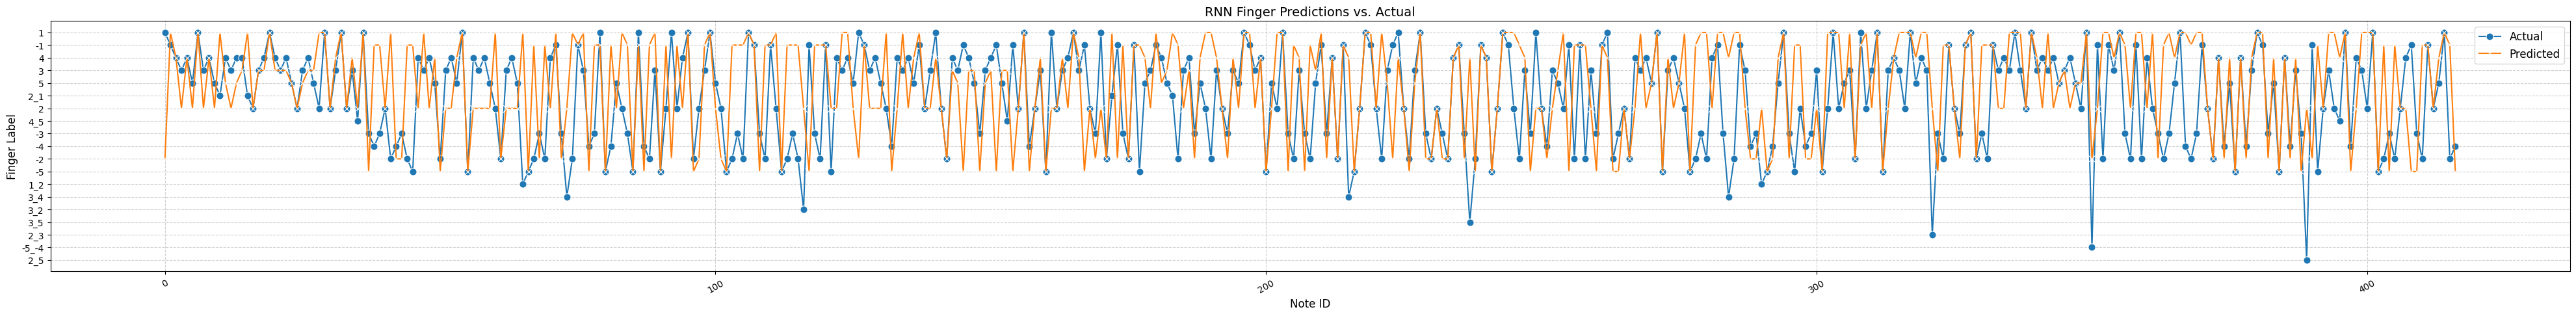

NameError: name 'lstm_true_labels' is not defined

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sequence_finger_predictions(note_ids, y_true, y_pred, model_name="RNN"):
    """
    Plots a line chart of actual vs. predicted finger labels across note indices.
    note_ids: array-like of note indices (for x-axis)
    y_true: array-like of actual finger labels (numeric or string)
    y_pred: array-like of predicted finger labels (numeric or string)
    """
    plt.figure(figsize=(50, 5))  # Increased width from 12 to 20
    sns.lineplot(x=note_ids, y=y_true, marker='o', markersize=8, label='Actual')
    sns.lineplot(x=note_ids, y=y_pred, marker='x', markersize=8, label='Predicted')
    
    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)  # Slight rotation for readability
    plt.grid(True, linestyle='--', alpha=0.6)  # Light grid for reference
    plt.legend(fontsize=12)
    plt.show()

# EXAMPLE USAGE with RNN predictions
plot_sequence_finger_predictions(
    note_ids=np.arange(len(rnn_true_labels)),  # or df["noteID"] if available
    y_true=rnn_true_labels,          
    y_pred=rnn_pred_labels,          
    model_name="RNN"
)

# Repeat for LSTM
plot_sequence_finger_predictions(
    note_ids=np.arange(len(lstm_true_labels)),
    y_true=lstm_true_labels,
    y_pred=lstm_pred_labels,
    model_name="LSTM"
)


# Transformer implementation

In [18]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: embedding size
        max_len: maximum sequence length
        """
        super().__init__()
        
        # Create a long enough 'pe' matrix of shape (max_len, d_model).
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sin to even indices and cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as a buffer so it’s saved in the model state but not trained
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: (seq_len, batch_size, d_model)
        Returns the same shape, but with positional encoding added.
        """
        seq_len = x.size(0)
        # Add the positional encoding to the input
        x = x + self.pe[:seq_len, :].unsqueeze(1)  # (seq_len, 1, d_model)
        return x


In [19]:
class TransformerTagger(nn.Module):
    def __init__(
        self,
        num_pitches,    # vocabulary size for spelled_pitch
        num_fingers,    # number of finger classes
        embed_dim=32,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1
    ):
        super().__init__()
        
        # 1) Embedding for pitch indices
        self.embedding = nn.Embedding(num_pitches, embed_dim)
        
        # 2) Positional encoding
        self.pos_encoder = PositionalEncoding(d_model=embed_dim)
        
        # 3) Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False  # By default, PyTorch uses (seq, batch, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 4) Final linear layer to map each token embedding -> finger label
        self.fc = nn.Linear(embed_dim, num_fingers)
        
        # We'll store the embed_dim for usage in forward
        self.embed_dim = embed_dim

    def forward(self, x):
        """
        x: (batch_size, seq_len) of pitch indices (torch.long)
        We want output shape: (batch_size, seq_len, num_fingers)
        """
        # Convert x to shape (seq_len, batch_size) for the transformer
        x = x.transpose(0, 1)  # => (seq_len, batch_size)
        
        # Embed: shape => (seq_len, batch_size, embed_dim)
        embedded = self.embedding(x)
        
        # Add positional encoding
        encoded = self.pos_encoder(embedded)  # (seq_len, batch_size, embed_dim)
        
        # Pass through Transformer
        transformer_out = self.transformer_encoder(encoded)  # (seq_len, batch_size, embed_dim)
        
        # Map to finger classes
        # shape => (seq_len, batch_size, num_fingers)
        logits = self.fc(transformer_out)
        
        # Return to shape (batch_size, seq_len, num_fingers)
        logits = logits.transpose(0, 1)  # => (batch_size, seq_len, num_fingers)
        return logits


In [27]:
# Let's say you have these from your RNN code
# train_sequence_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3)
# evaluate_sequence_model(model, test_loader)

###############################################
# Train the Transformer Tagger
###############################################
transformer_model = TransformerTagger(
    num_pitches=len(pitch_vocab),   # Same as in RNN
    num_fingers=len(finger_vocab),  # Same as in RNN
    embed_dim=512,  # Increased from 128 to 512
    nhead=8,        # Increased from 4 to 8
    num_layers=6,   # Increased from 2 to 6
    dim_feedforward=2048,  # Increased from 128 to 2048
    dropout=0.05   # Reduced dropout for better training
)

print("\n=== Training TRANSFORMER ===")
train_sequence_model(transformer_model, train_loader, val_loader, num_epochs=20, lr=1e-3)

test_acc_transformer = evaluate_sequence_model(transformer_model, test_loader)
print(f"Transformer Test Accuracy = {test_acc_transformer*100:.2f}%")


/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Training TRANSFORMER ===
Epoch 1/20, Loss=2.3600, ValAcc=0.2437
Epoch 2/20, Loss=1.9502, ValAcc=0.2303
Epoch 3/20, Loss=1.8427, ValAcc=0.2701
Epoch 4/20, Loss=1.8045, ValAcc=0.3063
Epoch 5/20, Loss=1.7374, ValAcc=0.2961
Epoch 6/20, Loss=1.7193, ValAcc=0.2939
Epoch 7/20, Loss=1.6682, ValAcc=0.2979
Epoch 8/20, Loss=1.6324, ValAcc=0.2908
Epoch 9/20, Loss=1.5869, ValAcc=0.2714
Epoch 10/20, Loss=1.5607, ValAcc=0.3212
Epoch 11/20, Loss=1.5188, ValAcc=0.3135
Epoch 12/20, Loss=1.4927, ValAcc=0.3119
Epoch 13/20, Loss=1.4656, ValAcc=0.3053
Epoch 14/20, Loss=1.4269, ValAcc=0.3119
Epoch 15/20, Loss=1.3862, ValAcc=0.3075
Epoch 16/20, Loss=1.3446, ValAcc=0.2919
Epoch 17/20, Loss=1.3272, ValAcc=0.3137
Epoch 18/20, Loss=1.2758, ValAcc=0.3126
Epoch 19/20, Loss=1.2673, ValAcc=0.3095
Epoch 20/20, Loss=1.2400, ValAcc=0.3077
Transformer Test Accuracy = 31.98%


In [25]:
import torch
import pandas as pd
import numpy as np
import os

def predict_piece_fingerings_transformer(
    model, file_path, pitch_to_idx, finger_to_idx, idx_to_finger, device=None
):
    """
    Predicts the fingerings for a single piece using a trained Transformer model.

    Args:
    - model: Trained Transformer model
    - file_path: Path to the piece txt file
    - pitch_to_idx: Dictionary mapping spelled pitches to integers
    - finger_to_idx: Dictionary mapping actual finger labels to integers
    - idx_to_finger: Dictionary mapping predicted integers back to finger labels
    - device: CUDA or CPU

    Returns:
    - note_ids: Array of note indices (to plot x-axis)
    - y_pred: Predicted finger labels (integer format)
    - y_true: Actual finger labels (integer format)
    - y_pred_labels: Predicted finger labels (string format)
    - y_true_labels: Actual finger labels (string format)
    - accuracy: Accuracy on the specific piece (if ground truth is available)
    """

    # 1. Load the piece data
    df = pd.read_table(
        file_path,
        sep="\t",
        skiprows=1,
        names=[
            "noteID",
            "onset_time",
            "offset_time",
            "spelled_pitch",
            "onset_velocity",
            "offset_velocity",
            "channel",
            "finger_number",
        ],
    )

    # 2. Convert spelled_pitch -> int (handle unseen pitches)
    df["spelled_pitch_int"] = df["spelled_pitch"].map(pitch_to_idx).fillna(0).astype(int)

    # 3. Convert finger_number -> int for accuracy comparison
    df["finger_int"] = df["finger_number"].astype(str).map(finger_to_idx).fillna(0).astype(int)

    # Extract sequences
    pitch_seq = df["spelled_pitch_int"].values
    y_true = df["finger_int"].values
    note_ids = df["noteID"].values

    # 4. Convert to PyTorch tensor with batch dimension (batch_size=1, seq_len)
    pitch_tensor = torch.tensor(pitch_seq, dtype=torch.long).unsqueeze(0)

    # 5. Move model & input to the correct device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pitch_tensor = pitch_tensor.to(device)
    model = model.to(device)
    model.eval()

    # 6. Run inference
    with torch.no_grad():
        logits = model(pitch_tensor)  # Shape: (1, seq_len, num_fingers)
        y_pred = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()  # Shape: (seq_len,)

    # 7. Decode predicted and actual labels
    y_pred_labels = [idx_to_finger.get(idx, "UNK") for idx in y_pred]
    y_true_labels = [idx_to_finger.get(idx, "UNK") for idx in y_true]

    # 8. Compute accuracy (if ground truth is available)
    accuracy = np.mean(y_pred == y_true) * 100.0

    return note_ids, y_pred, y_true, y_pred_labels, y_true_labels, accuracy

##################################
# Example Usage
##################################
piece_file = "003-1_fingering.txt"  # The piece to predict
file_path = os.path.join(directory_path, piece_file)

# Reverse mapping for decoding
idx_to_finger = {v: k for k, v in finger_to_idx.items()}

# Predict
note_ids, y_pred, y_true, y_pred_labels, y_true_labels, accuracy = predict_piece_fingerings_transformer(
    model=transformer_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_idx,
    finger_to_idx=finger_to_idx,
    idx_to_finger=idx_to_finger,
)

# Print Results
print(f"\n=== Transformer Predictions for {piece_file} ===")
print("Predicted fingerings:", y_pred_labels)
print("Actual fingerings:   ", y_true_labels)
print(f"Accuracy on this piece: {accuracy:.2f}%")



=== Transformer Predictions for 003-1_fingering.txt ===
Predicted fingerings: ['-1', '-1', '3', '2', '4', '3', '-1', '3', '3', '3', '2', '5', '3', '5', '5', '2', '3', '5', '5', '4', '5', '5', '5', '5', '3', '5', '5', '5', '4', '2', '4', '4', '2', '4', '5', '3', '3', '-2', '-2', '-2', '2', '-2', '-3', '-2', '-2', '-3', '5', '5', '4', '5', '-2', '3', '5', '5', '3', '-5', '3', '2', '3', '5', '1', '-2', '2', '3', '5', '1', '-5', '-2', '-2', '-2', '3', '-1', '-2', '2', '-2', '-1', '3', '-5', '-3', '-2', '-5', '-5', '2', '-1', '-3', '-5', '-2', '-5', '-3', '-1', '-5', '-2', '-2', '-2', '1', '-1', '-5', '-2', '-2', '-1', '2', '-2', '-5', '-5', '-5', '-5', '-1', '-3', '-5', '-5', '-3', '-2', '-5', '-5', '-5', '-5', '-1', '-5', '-5', '-5', '-5', '-5', '2', '1', '2', '3', '-2', '-4', '1', '2', '2', '1', '-3', '3', '2', '4', '3', '-1', '2', '4', '3', '3', '-2', '3', '5', '-2', '5', '4', '-5', '5', '5', '-1', '4', '5', '-5', '3', '1', '-5', '3', '3', '-5', '2', '3', '3', '3', '-1', '3', '-2', '3'

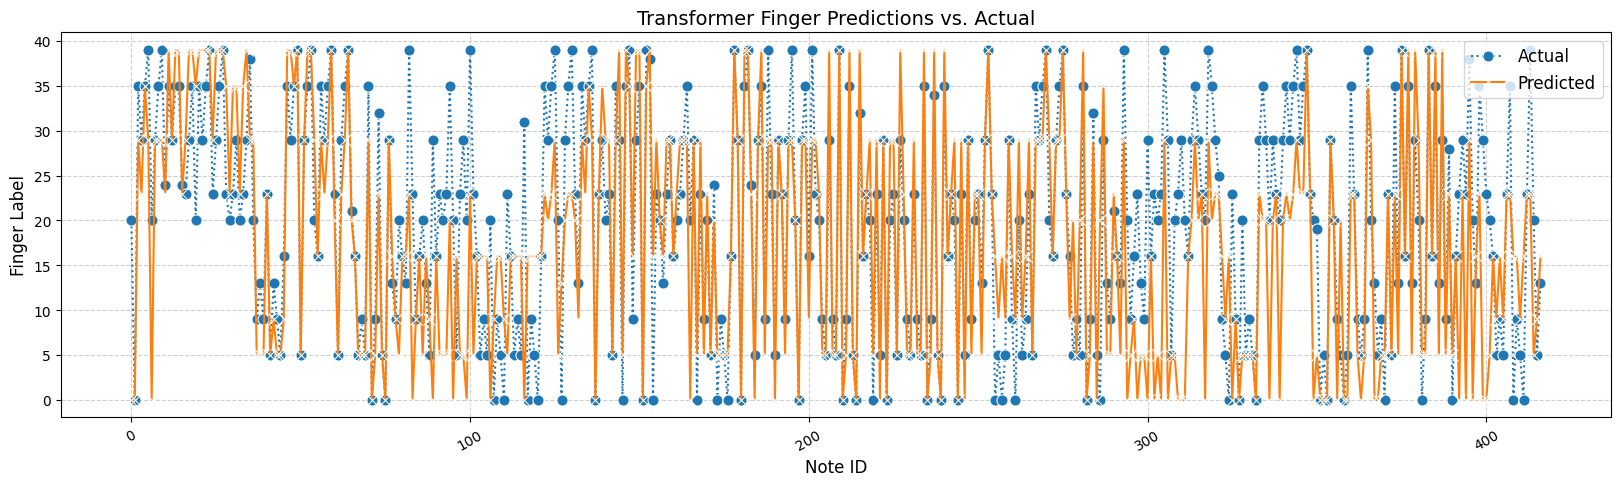

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_transformer_predictions(note_ids, y_true, y_pred, model_name="Transformer"):
    """
    Plots a line chart of actual vs. predicted finger labels across note indices.
    """
    plt.figure(figsize=(20, 5))  # Wide figure for better visibility
    sns.lineplot(x=note_ids, y=y_true, marker='o', markersize=8, label='Actual', linestyle="dotted")
    sns.lineplot(x=note_ids, y=y_pred, marker='x', markersize=8, label='Predicted', linestyle="-")
    
    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)  # Slight rotation for readability
    plt.grid(True, linestyle='--', alpha=0.6)  # Light grid for reference
    plt.legend(fontsize=12)
    plt.show()

# Plot predictions for Transformer
plot_transformer_predictions(
    note_ids=note_ids, 
    y_true=y_true, 
    y_pred=y_pred, 
    model_name="Transformer"
)


# RANDOM USEFUL CODE EXAMPLES BELOW:
## How to load in a bunch of sequences from a specific file

In [15]:
sequence_length = 10  # Define the sequence length

for filename in os.listdir(directory_path)[:5]:  # Iterate through files
    file_path = os.path.join(directory_path, filename)
    
    fingering_label, _ = filename.split('_')  # Extract piece and fingering type
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)
    
    # Load the data
    df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
        "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", 
        "offset_velocity", "channel", "finger_number"
    ])
    
    # Separate features and labels
    num_data, num_features = df.shape
    x = df.iloc[:, 0:num_features - 1]
    y = df.iloc[:, num_features - 1]
    x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
    y = y.map(finger_to_int_mapping)  # Map finger labels to integers
    
    # Create sequences
    x_sequences, y_sequences = create_sequences(x, y, sequence_length=sequence_length)

    print(f"x_sequences shape: {x_sequences.shape}")
    print(f"y_sequences shape: {y_sequences.shape}")


x_sequences shape: (280, 10, 7)
y_sequences shape: (280, 10)
x_sequences shape: (582, 10, 7)
y_sequences shape: (582, 10)
x_sequences shape: (339, 10, 7)
y_sequences shape: (339, 10)
x_sequences shape: (184, 10, 7)
y_sequences shape: (184, 10)
x_sequences shape: (252, 10, 7)
y_sequences shape: (252, 10)


## Fitting a logistic regression model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Initialize lists to accumulate all training data
X = []
Y = []

sequence_length = 5  # Define the sequence length

# Iterate through files
for filename in os.listdir(directory_path)[:100]:  # Process the first 10 files
    file_path = os.path.join(directory_path, filename)
    
    fingering_label, _ = filename.split('_')  # Extract piece and fingering type
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)
    
    # Load the data
    df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
        "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", 
        "offset_velocity", "channel", "finger_number"
    ])
    
    # Separate features and labels
    num_data, num_features = df.shape
    x = df.iloc[:, 0:num_features - 1]
    y = df.iloc[:, num_features - 1]
    x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
    y = y.map(finger_to_int_mapping)  # Map finger labels to integers
    
    # Create sequences
    x_sequences, y_sequences = create_sequences(x, y, sequence_length=sequence_length)
    
    # Flatten x_sequences into [num_sequences * sequence_length, num_features]
    num_sequences, seq_len, num_features = x_sequences.shape
    x_flat = x_sequences.reshape(num_sequences * seq_len, num_features)  # Flatten sequences
    y_flat = y_sequences.flatten()  # Flatten y_sequences to match x_flat
    
    # Append to global X and Y
    X.append(x_flat)
    Y.append(y_flat)

# Concatenate all data into single arrays
X = np.vstack(X)  # Combine all x_flat into a single array
Y = np.concatenate(Y)  # Combine all y_flat into a single array

# Fit a logistic regression model to the combined data
logistic_model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')  # Multinomial for multi-class classification
logistic_model.fit(X, Y)

# Predict on training data
Y_pred = logistic_model.predict(X)

# Compute and print metrics
accuracy = accuracy_score(Y, Y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(Y, Y_pred)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")


/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Overall Accuracy: 0.2016
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.19      0.83      0.31     15753
           2       0.16      0.15      0.15     14228
           3       0.00      0.00      0.00     11627
           4       0.00      0.00      0.00      9013
           5       0.20      0.01      0.01      9111
           6       0.14      0.07      0.09      6734
           7       0.00      0.00      0.00      3388
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        20
          12       0.00      0.00      0.00      3847
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        35
          17       0.00      0.00      0.00        15
          19       0.00      0.00

/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1

In [76]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Load the piece and preprocess
file_path = os.path.join(directory_path, "001-1_fingering.txt")  # Replace with your piece file name

df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
    "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", 
    "offset_velocity", "channel", "finger_number"
])

# Preprocess features
x = df.iloc[:, :-1]
y = df.iloc[:, -1]
x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
y = y.map(finger_to_int_mapping)  # Map finger labels to integers

# Create sequences with padding if needed
def create_sequences_with_padding(x_df, sequence_length=10):
    """
    Create sequences with padding if the number of rows is not divisible by the sequence length.
    """
    num_notes, num_features = x_df.shape
    padded_length = ((num_notes + sequence_length - 1) // sequence_length) * sequence_length  # Round up
    padding_needed = padded_length - num_notes

    # Add zero padding to the end of the DataFrame
    x_padded = np.pad(x_df.values, ((0, padding_needed), (0, 0)), mode="constant", constant_values=0)

    # Reshape into sequences
    x_sequences = x_padded.reshape(-1, sequence_length, num_features)
    return x_sequences, num_notes  # Return original number of notes for truncation later

sequence_length = 10
x_sequences, original_num_notes = create_sequences_with_padding(x, sequence_length=sequence_length)

# Flatten sequences for prediction
num_sequences, seq_len, num_features = x_sequences.shape
x_flat = x_sequences.reshape(num_sequences * seq_len, num_features)

# Predict fingerings
predicted_fingerings = logistic_model.predict(x_flat)

# Reshape predictions to match sequence structure
predicted_fingerings = predicted_fingerings.reshape(num_sequences, seq_len)

# Truncate padded predictions to match original number of notes
predicted_fingerings = predicted_fingerings.flatten()[:original_num_notes]  # Remove padding

# Output predicted fingerings
print("Predicted Fingerings:")
print(predicted_fingerings)
print(y.to_numpy())

# Compute and print metrics
accuracy = accuracy_score(Y, Y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(Y, Y_pred)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Predicted Fingerings:
[ 1  1  1  1  1  1  1 46 55  1 55 55  1 55  1  1 55  1 55 55  1 55  1  1
 55  1  1  1  1  1  1 55  1 55 55  1 55  1  1 55  1 55 55  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1  1  0 55  1 55 55  1
 55  1  1 55 55  1 55  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1  1  1 55  1 55  1  1  1 55  1  1 55 57
 55 55 57 55 55 55  1  1 55  1  1 55  1  1 55  1  1 57 55 55 55 55 55 55
 55 57  1  1 55  1  1 55  1  1 55  1  0 55 55 55 55 55 55 55 55 55  1  1
 55  1  1 55  1  1 55  1  0 55 57 55 55 55 55 55 57 55  1  1 55  1  1 55
  1  1 55  1  1 55 57  0 57 55  1 55 57  1 55 57  1 57 55  0 55 55  0 55
 55  0 55 55  0 55 55  1 55 55  1 57 55  0 55 55  0 55 55  0 57 57  0 55
 57 57 55 57  1  1 55  1  0 55 57  1 55  1  1  1 57  1 57  1 57  1 55  1
 55  1 57  0 55  1 57  1 57  0 57  1 57  0 57  0 57  1 55  1 57  1 55  1
 55  1  1 57  1  1 55  1  1  

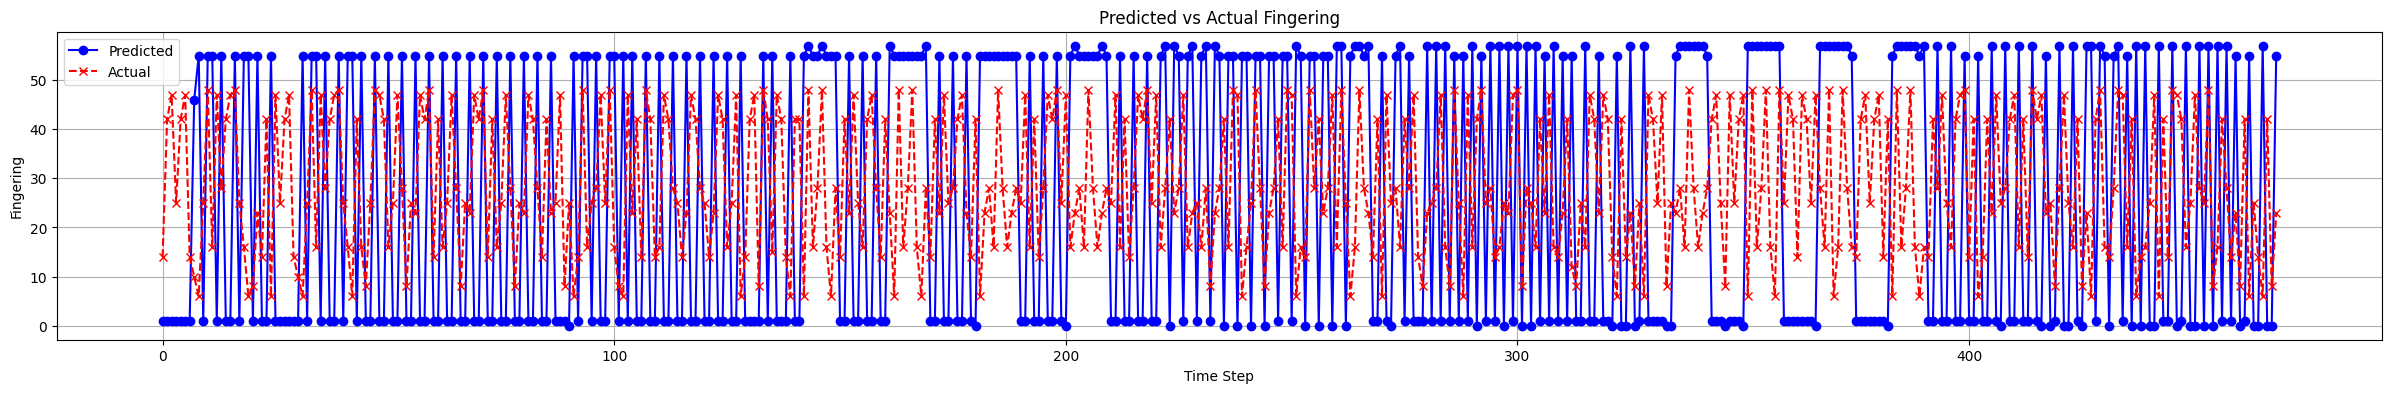

In [77]:
# VISUALIZATION:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Step 6: Visualize the predictions vs actual labels
def visualize_comparison(preds, actuals):
    fig, ax = plt.subplots(figsize=(30, 4))
    x = range(len(preds))
    ax.plot(x, preds, label='Predicted', marker='o', linestyle='-', color='b')
    ax.plot(x, actuals, label='Actual', marker='x', linestyle='--', color='r')

    ax.set_xlabel('Time Step')
    ax.set_ylabel('Fingering')
    ax.set_title('Predicted vs Actual Fingering')
    ax.legend()
    plt.grid(True)
    plt.show()

# Visualize comparison for a few sequences
visualize_comparison(predicted_fingerings, y.to_numpy())

#   OOOOOOOOOOOOOLLLLLLLLLLLLLLDDDDDDDDDDDD

In [12]:
my_linear_model = LinearRegressionBaseline(num_features - 1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_linear_model.parameters(), lr=1e-2)    # Needs a VERY small learning rate, else NaN.


# normalize inputs before feeding to model
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()


print(x.shape)
print(y.shape)
print(my_linear_model(x).shape)


torch.Size([289, 7])
torch.Size([289, 1])
torch.Size([289, 1])


In [13]:

epochs = 5000
for epoch in range(epochs):
    # Forward pass
    y_pred = my_linear_model(x)
    loss = criterion(y_pred, y)
#     print(x.shape)
#     print(y.shape)
#     print(y_pred)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [5000/5000], Loss: 0.7200


In [14]:
# Check on testing set

x_test = x
y_test = y




# Ensure your model is in evaluation mode
my_linear_model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    # Forward pass: Predict on the test set
    y_test_pred = my_linear_model(x_test)

    # Calculate the loss on the test set
    test_loss = criterion(y_test_pred, y_test)

    # Optional: Convert predictions to numpy for further analysis if needed
    y_test_pred_np = y_test_pred.cpu().numpy() if y_test_pred.is_cuda else y_test_pred.numpy()
    y_test_np = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Print the results
print("Test Results:")
print(f"Test Loss: {test_loss.item():.4f}")
print("Sample Predictions:")
for i in range(min(5, len(y_test_pred))):  # Display up to 5 predictions
    print(f"Predicted: {y_test_pred_np[i]}, Actual: {y_test_np[i]}")

Test Results:
Test Loss: 0.7199
Sample Predictions:
Predicted: [0.2364006], Actual: [0.8806283]
Predicted: [0.0821104], Actual: [0.54707444]
Predicted: [0.09154606], Actual: [0.8806283]
Predicted: [0.3571701], Actual: [0.54707444]
Predicted: [-0.57786465], Actual: [-1.7878023]


In [15]:
# Compare with Scikit Normal Equation Result

import numpy as np
from sklearn.linear_model import LinearRegression
import torch

# Assuming x and y are your training tensors
x_np = x.numpy() if isinstance(x, torch.Tensor) else x
y_np = y.numpy() if isinstance(y, torch.Tensor) else y
y_np = y_np.reshape(-1)

print(x_np.shape)
print(y_np.shape)


# Validate with Scikit-Learn
lr = LinearRegression(fit_intercept=True)
lr.fit(x_np, y_np)

# Print Scikit-Learn weights for comparison
print("Weights (Scikit-Learn):", np.hstack([lr.intercept_, lr.coef_]))


x_test_np = x_np
y_test_np = y_np

# Predict on the test set
y_test_pred = lr.predict(x_test_np)

# Compute Mean Squared Error (MSE) loss
test_loss = np.mean((y_test_pred - y_test_np) ** 2)

# Print the loss
print("Test Loss (Scikit-Learn):", test_loss)    # About the same loss: 0.53!

(289, 7)
(289,)
Weights (Scikit-Learn): [-9.9855537e+01  6.3732588e-01  1.2104809e-01 -3.0192924e+00
  2.3201710e-02  2.7132304e+00  2.4308480e-09 -9.6365234e+01]
Test Loss (Scikit-Learn): 0.16213986


# Idea 2: Add more layers

In [16]:
# deep neural net with more layers

class DeepNeuralNet(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(DeepNeuralNet, self).__init__()
        self.mlp_layer = nn.Sequential(
            nn.Linear(input_dims, 4 * input_dims),
            nn.ReLU(),
            nn.Linear(4 * input_dims, output_dims),
        )


    def forward(self, x):
        return self.mlp_layer(x)

In [17]:
dnn_model = DeepNeuralNet(num_features - 1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-2)    # Needs a VERY small learning rate, else NaN.


# normalize inputs before feeding to model
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()


print(x.shape)
print(y.shape)
print(dnn_model(x).shape)


# Adding more layers helps a lot!

epochs = 1000
for epoch in range(epochs):
    # Forward pass
    y_pred = dnn_model(x)
    loss = criterion(y_pred, y)
#     print(x.shape)
#     print(y.shape)
#     print(y_pred)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

torch.Size([289, 7])
torch.Size([289, 1])
torch.Size([289, 1])


# Testing code

Testing on some random other piece

In [18]:
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path) and filename == os.listdir(directory_path)[1]:
        test_df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        print(filename)

x_test = test_df.iloc[:, 0:num_features - 1]
y_test = test_df.iloc[:, num_features - 1]

x_test['spelled_pitch'] = x_test['spelled_pitch'].map(pitch_to_int_mapping)


# print(x_test)

# NORMALIZE FIRST
# Normalize x_test
for col in x_test.columns:
    std = x_test[col].std()
    if std == 0:  # Check if all values are the same
        x_test[col] = 0  # Assign all entries in this column to 0
    else:
        x_test[col] = (x_test[col] - x_test[col].mean()) / std

# Normalize y_test
y_test_std = y_test.std()
if y_test_std == 0:  # Check if all values are the same
    y_test = 0  # Assign all entries in y_test to 0
else:
    y_test = (y_test - y_test.mean()) / y_test_std



x_test = torch.tensor(x_test.values.tolist(), dtype=torch.float32)
y_test = torch.tensor(y_test.values.astype(float).tolist())
y_test = y_test.unsqueeze(1)   # conver from size [289] to size [289, 1]


# print(y_test)


# print(x_test.isna().sum())
# print(y_test.shape)

026-5_fingering.txt


In [19]:

# Check on testing set

# x_test = x
# y_test = y

# print(x_test)
# print(y_test)


# Ensure your model is in evaluation mode
dnn_model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    # Forward pass: Predict on the test set
    y_test_pred = dnn_model(x_test)

    # Calculate the loss on the test set
    test_loss = criterion(y_test_pred, y_test)

    # Optional: Convert predictions to numpy for further analysis if needed
    y_test_pred_np = y_test_pred.cpu().numpy() if y_test_pred.is_cuda else y_test_pred.numpy()
    y_test_np = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Print the results
print("Test Results:")
print(f"Test Loss: {test_loss.item():.4f}")
print("Sample Predictions:")
for i in range(min(5, len(y_test_pred))):  # Display up to 5 predictions
    print(f"Predicted: {y_test_pred_np[i]}, Actual: {y_test_np[i]}")

Test Results:
Test Loss: 997.6591
Sample Predictions:
Predicted: [-6.156381], Actual: [0.29965785]
Predicted: [-5.7688727], Actual: [0.6164696]
Predicted: [-6.2006125], Actual: [1.566905]
Predicted: [-62.680935], Actual: [-1.6012129]
Predicted: [-62.60875], Actual: [-0.33396572]


# Idea 3: Seq to Seq Modeling

Obviously the above doesn't work at all because the specific fingering DEPENDS on the previous fingerings!

In [113]:
# Strategy 1: Recurrent Neural Network

# rnn = nn.RNN(10, 20, 2)
# i = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# output, hn = rnn(i, h0)


# 20, 512 seems to be OK: gets to a loss of like 0.5 or so - 21% accuracy
# seq 10, hidden 1024 also seems to get around 0.58. Slightly worse 13% - seems like more sequence length helps more than a larger hidden size
SEQ_LENGTH = 30
HIDDEN_SIZE = 512


In [114]:
# Initialize an empty list to store DataFrames
dataframes = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        # Read the file into a DataFrame
        new_df = pd.read_table(
            file_path,
            sep="\t",
            skiprows=1,
            names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"]
        )

        dataframes.append(new_df)

# Concatenate all DataFrames in the list into a single DataFrame
train_df = pd.concat(dataframes, ignore_index=True)

### NEED TO NORMALIZE FULL DATAFRAME FIRST!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_columns = ['onset_time', 'offset_time', 'onset_velocity', 'offset_velocity']
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])




# some labels have "_" in them: default to using the int on the left!
train_df.iloc[:, num_features - 1] = train_df.iloc[:, num_features - 1].where(
    ~train_df.iloc[:, num_features - 1].str.contains('_', na=False),
    train_df.iloc[:, num_features - 1].str.split('_').str[0]
).astype(int)


# train_df = train_df.head(20000)  # for testing, we will only take the first 10000 rows. Can use more for training when you have GPUs



# Split into features (X) and target (y)
x_train = train_df.iloc[:, 0:num_features - 1]
y_train = train_df.iloc[:, num_features - 1]



# Map "spelled_pitch" to integers using the provided mapping
x_train['spelled_pitch'] = x_train['spelled_pitch'].map(pitch_to_int_mapping)
y_train = y_train.astype(int)

# Ensure target values (y_train) are positive for CrossEntropyLoss
y_train += 5

# # Print the maximum value of y_train to verify
# print("Maximum y_train value:", y_train.max())
# print(x_train)
# print(y_train)

In [115]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def create_sequences(x_df, y_series, sequence_length):
    x_sequences = []
    y_sequences = []
    for i in range(len(x_df) - sequence_length + 1):
        # Extract a sequence of notes (features)
        x_seq = x_df.iloc[i:i + sequence_length].values  # Shape: [T, num_features]
        # Extract the corresponding sequence of finger labels
        y_seq = y_series.iloc[i:i + sequence_length].values  # Shape: [T]
        x_sequences.append(x_seq)
        y_sequences.append(y_seq)

    return np.array(x_sequences, dtype=np.float32), np.array(y_sequences)

# Example usage
sequence_length = SEQ_LENGTH  # Define the sequence length
x_sequences, y_sequences = create_sequences(x_train, y_train, sequence_length)

# Convert to PyTorch tensors
x_sequences = torch.tensor(x_sequences, dtype=torch.float32)  # Shape: [num_sequences, T, num_features]
y_sequences = torch.tensor(y_sequences, dtype=torch.long)  # Shape: [num_sequences, T]

# print(x_sequences)
# print(y_sequences)

In [116]:
class PianoDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Create Dataset
dataset = PianoDataset(x_sequences, y_sequences)

from sklearn.model_selection import train_test_split

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    x_sequences, y_sequences, test_size=0.2, random_state=42
)

# Create Dataset objects
train_dataset = PianoDataset(x_train, y_train)
test_dataset = PianoDataset(x_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [117]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape)  # [batch_size, sequence_length, num_features]
    print(y_batch.shape)  # [batch_size, sequence_length]
    # Pass x_batch to your RNN model


torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([5

In [118]:
# import torch
# import torch.nn as nn

# class SeqToSeqTransformer(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_heads=8, num_layers=4, dropout=0.1):
#         super(SeqToSeqTransformer, self).__init__()
#         # Embedding layer to project input features to hidden_size
#         self.embedding = nn.Linear(input_size, hidden_size)

#         # Transformer encoder
#         self.transformer = nn.Transformer(
#             d_model=hidden_size,
#             nhead=num_heads,
#             num_encoder_layers=num_layers,
#             num_decoder_layers=num_layers,
#             dim_feedforward=hidden_size * 4,
#             dropout=dropout,
#             batch_first=True
#         )

#         # Fully connected layer to map transformer output to output_size
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Embed input to the same dimension as hidden_size
#         x = self.embedding(x)

#         # For simplicity, using encoder-only transformer (typical for sequence classification or tagging)
#         # If needed, you can define and use a separate decoder
#         x = self.transformer(x, x)  # Pass through the transformer encoder

#         # Map to the output space
#         x = self.fc(x)
#         return x


# # Example usage

# # Assuming x_sequences is your input data
# input_size = x_sequences.shape[2]  # Number of features
# hidden_size = 512
# output_size = 11   # Number of unique finger labels

# # Instantiate and move the model to the GPU if available
# model = SeqToSeqTransformer(input_size, hidden_size, output_size).to(device)

# # Print model summary
# # print(model)

# SEQUENCE TO SEQUENCE MODULE
import torch.nn as nn

class SeqToSeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SeqToSeqRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Map hidden state to output size

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN output: [batch_size, sequence_length, hidden_size]
        out = self.fc(out)    # Output: [batch_size, sequence_length, output_size]
        return out

# Example
input_size = x_sequences.shape[2]  # Number of features
hidden_size = HIDDEN_SIZE
output_size = 11 # Number of unique finger labels
model = SeqToSeqRNN(input_size, hidden_size, output_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)



In [126]:
# Training Loop
epochs = 100
model.train()  # Ensure the model is in training mode

for epoch in range(epochs):
    epoch_loss = 0

    for x_batch, y_batch in train_loader:
        # Move data to the device (GPU or CPU)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)  # Shape: [batch_size, sequence_length, output_size]
        loss = criterion(outputs.view(-1, output_size), y_batch.view(-1))  # Flatten for CrossEntropyLoss
        
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")




Epoch [1/100], Loss: 0.4455
Epoch [2/100], Loss: 0.4435
Epoch [3/100], Loss: 0.4438
Epoch [4/100], Loss: 0.4438
Epoch [5/100], Loss: 0.4441
Epoch [6/100], Loss: 0.4420
Epoch [7/100], Loss: 0.4437
Epoch [8/100], Loss: 0.4417
Epoch [9/100], Loss: 0.4409
Epoch [10/100], Loss: 0.4398
Epoch [11/100], Loss: 0.4397
Epoch [12/100], Loss: 0.4395
Epoch [13/100], Loss: 0.4388
Epoch [14/100], Loss: 0.4395
Epoch [15/100], Loss: 0.4382
Epoch [16/100], Loss: 0.4396
Epoch [17/100], Loss: 0.4373
Epoch [18/100], Loss: 0.4378
Epoch [19/100], Loss: 0.4366
Epoch [20/100], Loss: 0.4367
Epoch [21/100], Loss: 0.4357
Epoch [22/100], Loss: 0.4364
Epoch [23/100], Loss: 0.4346
Epoch [24/100], Loss: 0.4343
Epoch [25/100], Loss: 0.4332
Epoch [26/100], Loss: 0.4345
Epoch [27/100], Loss: 0.4332
Epoch [28/100], Loss: 0.4329
Epoch [29/100], Loss: 0.4325
Epoch [30/100], Loss: 0.4321
Epoch [31/100], Loss: 0.4321
Epoch [32/100], Loss: 0.4322
Epoch [33/100], Loss: 0.4317
Epoch [34/100], Loss: 0.4312
Epoch [35/100], Loss: 0

In [121]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(x_batch)  # Shape: [batch_size, sequence_length, num_classes]

            # Calculate loss
            loss = criterion(outputs.view(-1, outputs.size(-1)), y_batch.view(-1))
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(outputs, dim=-1)  # Shape: [batch_size, sequence_length]
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

            # Accuracy calculation
            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.numel()

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)  # Shape: [total_sequences, sequence_length]
    all_targets = torch.cat(all_targets, dim=0)  # Shape: [total_sequences, sequence_length]

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy, all_preds, all_targets

# Assuming test_loader and model are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Evaluate the model
test_loss, test_accuracy, all_preds, all_targets = evaluate_model(model, test_loader, criterion, device)

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.5170
Test Accuracy: 78.67%


In [122]:
# Visualize predictions and true labels
import random

def visualize_predictions(preds, targets, num_examples=5):
    print("Example Predictions:")
    for i in range(num_examples):
        idx = random.randint(0, preds.size(0) - 1)  # Random sequence index
        print(f"Sequence {i + 1}:")
        print(f"Predicted: {preds[idx].tolist()}")
        print(f"Actual:    {targets[idx].tolist()}")
        print()

# Show some example predictions
visualize_predictions(all_preds, all_targets)


Example Predictions:
Sequence 1:
Predicted: [6, 4, 10, 6, 1, 7, 4, 6, 7, 4, 9, 6, 7, 0, 10, 6, 8, 4, 10, 6, 7, 9, 6, 8, 4, 9, 6, 0, 10, 7]
Actual:    [7, 4, 8, 6, 2, 7, 4, 6, 7, 4, 9, 6, 7, 0, 10, 6, 8, 4, 10, 6, 7, 10, 6, 8, 4, 9, 6, 2, 10, 7]

Sequence 2:
Predicted: [4, 3, 3, 8, 0, 2, 4, 8, 0, 2, 4, 8, 0, 2, 4, 0, 2, 4, 8, 8, 0, 2, 4, 0, 2, 4, 7, 0, 2, 4]
Actual:    [4, 2, 4, 7, 0, 2, 4, 8, 0, 2, 4, 8, 0, 2, 4, 0, 2, 4, 8, 8, 0, 2, 4, 0, 2, 4, 7, 0, 2, 4]

Sequence 3:
Predicted: [4, 10, 6, 7, 8, 0, 9, 6, 7, 4, 3, 9, 6, 7, 2, 4, 10, 6, 7, 2, 4, 10, 6, 7, 1, 4, 10, 6, 7, 1]
Actual:    [1, 10, 6, 7, 8, 0, 9, 6, 7, 4, 3, 10, 6, 8, 2, 4, 10, 6, 7, 3, 2, 10, 6, 7, 4, 3, 10, 6, 7, 2]

Sequence 4:
Predicted: [6, 0, 4, 8, 4, 4, 6, 4, 3, 6, 2, 4, 7, 3, 2, 6, 2, 4, 7, 3, 2, 6, 1, 4, 7, 1, 4, 8, 2, 2]
Actual:    [6, 3, 4, 7, 2, 4, 8, 3, 2, 6, 1, 4, 7, 3, 2, 6, 1, 4, 7, 3, 2, 6, 3, 2, 7, 1, 4, 8, 3, 2]

Sequence 5:
Predicted: [4, 9, 9, 2, 4, 10, 6, 2, 4, 9, 8, 6, 0, 4, 9, 6, 0, 4, 6, 7, 0, 4, 9, 

# Pretty good!

Now let's actually try printing out the fingerings for a random piece

In [123]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load the specific file
specific_file = os.listdir(directory_path)[10]  # Replace 10 with the desired index
file_path = os.path.join(directory_path, specific_file)

my_df = pd.DataFrame()

if os.path.isfile(file_path):
    print(f"ANNOTATING FILE: {specific_file}")
    my_df = pd.read_table(
        file_path,
        sep="\t",
        skiprows=1,
        names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"]
    )


column_name = "finger_number"  # Replace with the actual column name
if not pd.api.types.is_integer_dtype(my_df[column_name]):
    my_df.iloc[:, -1] = my_df.iloc[:, -1].where(
        ~my_df.iloc[:, num_features - 1].str.contains('_', na=False),
        my_df.iloc[:, num_features - 1].str.split('_').str[0]
    ).astype(int)




# Step 2: Preprocess the data
# Normalize and map spelled_pitch
my_df['spelled_pitch'] = my_df['spelled_pitch'].map(pitch_to_int_mapping)

features = my_df.iloc[:, :-1]
labels = my_df.iloc[:, -1].astype(int) + 5  # Adjust labels if necessary for CrossEntropyLoss



# Replace NaN or invalid mappings if needed
# features.fillna(0, inplace=True)


# Normalize features: CAN'T JUST DO MEAN / STD SINCE STD MIGHT BE 0!!!
for col in features.columns:
    std = features[col].std()
    if std == 0:  # Check if all values are the same
        features[col] = 0  # Assign all entries in this column to 0
    else:
        features[col] = (features[col] - features[col].mean()) / std









# Convert to PyTorch tensors
x_piece = torch.tensor(features.values, dtype=torch.float32).unsqueeze(0)  # Shape: [1, seq_len, num_features]
y_piece = torch.tensor(labels.values, dtype=int).unsqueeze(0)  # Shape: [1, seq_len]



# Step 3: Create a DataLoader
piece_dataset = TensorDataset(x_piece, y_piece)
piece_loader = DataLoader(piece_dataset, batch_size=1, shuffle=False)

# Step 4: Predict the fingering sequence
model.eval()
predicted_fingering = []

with torch.no_grad():
    for x_batch, _ in piece_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)  # Shape: [1, seq_len, num_classes]
        preds = torch.argmax(outputs, dim=-1)  # Shape: [1, seq_len]
        predicted_fingering = preds.squeeze(0).tolist()

# Step 5: Output the predictions
print(f"Predicted Fingering Sequence for {specific_file}:")
print(predicted_fingering)


# print out actual
print(f"Actual Fingering:")
print(labels.tolist())


# print out overall "loss"


ANNOTATING FILE: 144-1_fingering.txt
Predicted Fingering Sequence for 144-1_fingering.txt:
[6, 0, 1, 6, 7, 9, 6, 0, 4, 6, 7, 9, 6, 6, 6, 0, 6, 0, 4, 3, 6, 0, 4, 7, 7, 10, 0, 4, 7, 4, 2, 4, 2, 6, 7, 9, 0, 4, 6, 0, 6, 0, 6, 0, 4, 3, 4, 0, 3, 2, 6, 7, 9, 0, 4, 6, 0, 6, 0, 6, 7, 4, 6, 0, 7, 0, 4, 7, 3, 4, 3, 6, 2, 7, 0, 2, 0, 3, 3, 7, 1, 6, 0, 2, 3, 3, 8, 2, 7, 9, 2, 0, 6, 0, 6, 3, 2, 4, 6, 0, 2, 6, 6, 0, 3, 4, 2, 2, 2, 6, 2, 9, 0, 6, 3, 2, 3, 6, 0, 4, 6, 10, 0, 3, 4]
Actual Fingering:
[7, 4, 2, 10, 9, 8, 6, 0, 3, 9, 10, 9, 8, 7, 8, 0, 6, 2, 4, 3, 8, 2, 4, 7, 8, 7, 3, 0, 2, 4, 0, 4, 1, 8, 10, 9, 0, 2, 8, 3, 7, 4, 6, 3, 0, 2, 4, 2, 4, 0, 7, 8, 10, 0, 2, 9, 3, 8, 4, 7, 6, 0, 7, 2, 9, 4, 0, 8, 3, 4, 0, 7, 3, 8, 4, 1, 3, 4, 0, 6, 1, 10, 4, 4, 2, 3, 9, 2, 10, 6, 4, 0, 9, 4, 10, 0, 3, 4, 6, 0, 2, 9, 9, 4, 3, 4, 3, 4, 1, 9, 0, 7, 4, 9, 0, 3, 4, 6, 0, 2, 10, 10, 4, 3, 4]


In [124]:
# print metrics for a specific piece
labels = labels.tolist()

# Calculate model loss and accuracy
def calc_metrics(preds, actuals, criterion):
    """
    Calculate the Cross-Entropy loss and accuracy for the predicted vs. actual labels.
    """

    num_wrong = 0

    if len(preds) != len(actuals):
        print("preds and actuals not of same size")
        return

    for i, value in enumerate(preds):
        if value != actuals[i]:
            num_wrong += 1
            print(f"error at pos {i}: note is {value} but should be {preds[i]}")

    print(f"num_wrong is {num_wrong}")
    print(f"len(preds) is {len(preds)}")

    accuracy = 1 - (num_wrong / len(preds))
    return accuracy

# print(predicted_fingering)
# print(labels.tolist())
# Calculate overall loss and accuracy
overall_accuracy = calc_metrics(predicted_fingering, labels, criterion)

# Print the overall loss and accuracy
# print(f"Overall Loss: {overall_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

error at pos 0: note is 6 but should be 6
error at pos 1: note is 0 but should be 0
error at pos 2: note is 1 but should be 1
error at pos 3: note is 6 but should be 6
error at pos 4: note is 7 but should be 7
error at pos 5: note is 9 but should be 9
error at pos 8: note is 4 but should be 4
error at pos 9: note is 6 but should be 6
error at pos 10: note is 7 but should be 7
error at pos 12: note is 6 but should be 6
error at pos 13: note is 6 but should be 6
error at pos 14: note is 6 but should be 6
error at pos 17: note is 0 but should be 0
error at pos 20: note is 6 but should be 6
error at pos 21: note is 0 but should be 0
error at pos 24: note is 7 but should be 7
error at pos 25: note is 10 but should be 10
error at pos 26: note is 0 but should be 0
error at pos 27: note is 4 but should be 4
error at pos 28: note is 7 but should be 7
error at pos 30: note is 2 but should be 2
error at pos 32: note is 2 but should be 2
error at pos 33: note is 6 but should be 6
error at pos 34: 

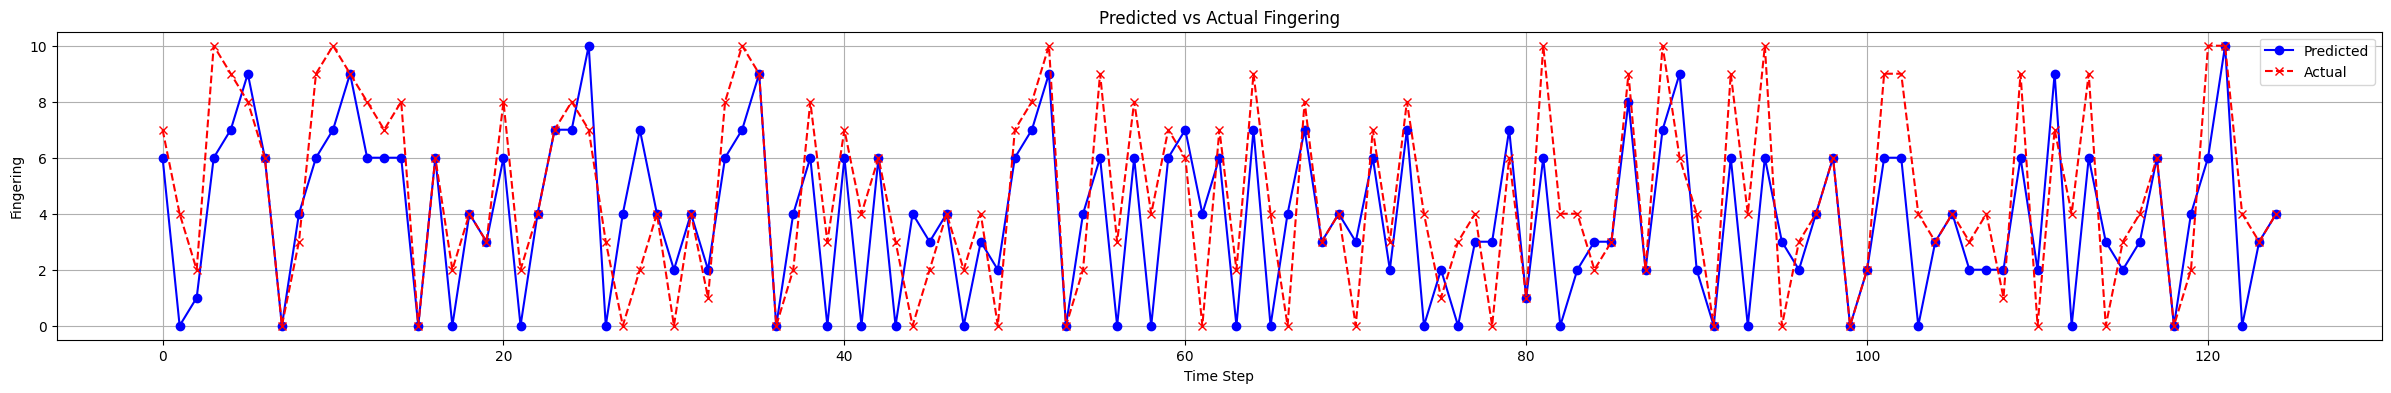

In [125]:
# VISUALIZATION:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Step 6: Visualize the predictions vs actual labels
def visualize_comparison(preds, actuals):
    fig, ax = plt.subplots(figsize=(30, 4))
    x = range(len(preds))
    ax.plot(x, preds, label='Predicted', marker='o', linestyle='-', color='b')
    ax.plot(x, actuals, label='Actual', marker='x', linestyle='--', color='r')

    ax.set_xlabel('Time Step')
    ax.set_ylabel('Fingering')
    ax.set_title('Predicted vs Actual Fingering')
    ax.legend()
    plt.grid(True)
    plt.show()

# Visualize comparison for a few sequences
visualize_comparison(predicted_fingering, labels)